In [ ]:
# TODO
# smooth heterozygosity + other histograms
# use 50kb window for best SNP

In [1]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("white")

DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure2"

sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
print(sscloo.shape)

locstats = pd.read_csv(os.path.join(DATADIR, "callstats", "hipstr.ALL.chr.v3.tab"), delim_whitespace=True)
locstats["pos"] = locstats.apply(lambda x: str(x["chrom"])+":"+str(x["start"]), 1)
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","pos"]).drop_duplicates(subset=['pos'])
locstats = pd.merge(locstats, id_start, on="pos", how="inner")
sscloo = pd.merge(sscloo, locstats, on="str", how="inner")
sscloo = sscloo[sscloo["FILTER"]=="."]
print(sscloo.shape)

Populating the interactive namespace from numpy and matplotlib
(445720, 38)


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(445725, 50)


In [2]:
# Set up colors
true_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
exp_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
hist_color="gray"
mycmap = plt.cm.jet
MINFREQ=0.05

In [3]:
position_to_id = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/position_to_id/ALL.position_to_id.txt", names=["pos", "str"], delim_whitespace=True)
expected_concordance = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/expected_concordance/ALL.exp_concord.txt", names=["pos", "exp_concord"], delim_whitespace=True)
expected_concordance = pd.merge(expected_concordance, position_to_id, on="pos", how="inner")

sscloo = pd.merge(sscloo, expected_concordance, on="str", how="inner")

In [4]:
sscloo[['loo_concordance']] = sscloo[['loo_concordance']].apply(pd.to_numeric)
sscloo[['loo_r']] = sscloo[['loo_r']].apply(pd.to_numeric)
sscloo[['wgs_eur_r']] = sscloo[['wgs_eur_r']].apply(pd.to_numeric)
sscloo[['wgs_eur_concordance']] = sscloo[['wgs_eur_concordance']].apply(pd.to_numeric)
sscloo["wgs_eur_concordance_100"] = sscloo["wgs_eur_concordance"]*100
sscloo["loo_concordance_100"] = sscloo["loo_concordance"]*100
sscloo["exp_concord_100"] = sscloo["exp_concord"]*100
sscloo["loo_r2"] = sscloo["loo_r"].apply(lambda x: x**2)
sscloo["wgs_eur_r2"] = sscloo["wgs_eur_r"].apply(lambda x: x**2)

In [53]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None, label="_nolegend_"):
    ax = ax if ax is not None else plt.gca()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    base_line, = ax.plot(x, y, color=color, label=label)
    if color is None:
        color = base_line.get_color()
    ax.fill_between(x, ymax, ymin, facecolor=color, alpha=alpha_fill)
    
def kde(vals, xlim, color=None, ax=None, bw=0.025):
    ax = ax if ax is not None else plt.gca()
    sns.kdeplot(vals, color=hist_color, shade=hist_color, bw=bw, ax=ax, legend=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Figure 2B: LOO Concordance vs. Heterozygosity

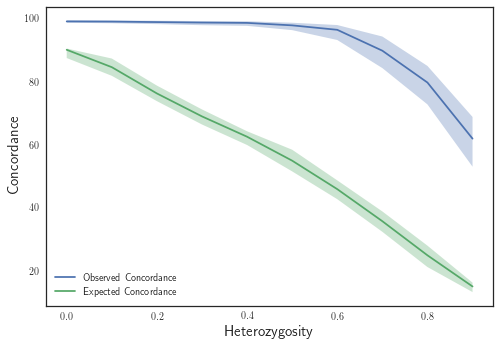

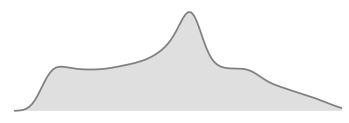

In [30]:
HETBIN=0.1
sscloo["hetbin"] = sscloo["het"].apply(lambda x: int(x/HETBIN)*HETBIN)
hetbins = np.unique(sscloo['hetbin'].values)
fullList = list()
for i in hetbins:
    fullList.append((sscloo[sscloo.hetbin==i]['loo_concordance'].values*100))

def GetLabel(x):
    if int(x*100)%10 == 0: return "%.2f"%x
    else: return ""
xticklabels = [GetLabel(x) for x in hetbins]

exp_median_val = sscloo[['hetbin','exp_concord_100']].groupby('hetbin').median().values
exp_max_val = sscloo[['hetbin','exp_concord_100']].groupby('hetbin').quantile(0.75).values
exp_min_val = sscloo[['hetbin','exp_concord_100']].groupby('hetbin').quantile(0.25).values
exp_x_val = sscloo[['hetbin','exp_concord_100']].groupby('hetbin').median().index.tolist()
exp_x_val = [float("%.1f"%x) for x in exp_x_val]

true_median_val = sscloo[['hetbin','loo_concordance_100']].groupby('hetbin').median().values
true_max_val = sscloo[['hetbin','loo_concordance_100']].groupby('hetbin').quantile(0.75).values
true_min_val = sscloo[['hetbin','loo_concordance_100']].groupby('hetbin').quantile(0.25).values
true_x_val = sscloo[['hetbin','loo_concordance_100']].groupby('hetbin').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]
    
plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed Concordance")
errorfill(exp_x_val, exp_median_val, yerr=[exp_min_val[:,0], exp_max_val[:,0]], color=exp_color, label="Expected Concordance")
plt.xlabel("Heterozygosity", size=15)
plt.ylabel("Concordance", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPATH, "%s_LOO_ConcordanceVsHet.pdf"%PREFIX));

# Histogram of hets for the top
fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
kde(sscloo["het"], (min(true_x_val), max(true_x_val)), color=hist_color, ax=ax)
fig.savefig(os.path.join(OUTPATH, "%s_LOO_ConcordanceVsHet_DIST.pdf"%PREFIX));

# Supplementary: SSC LOO Concordance vs. num alleles

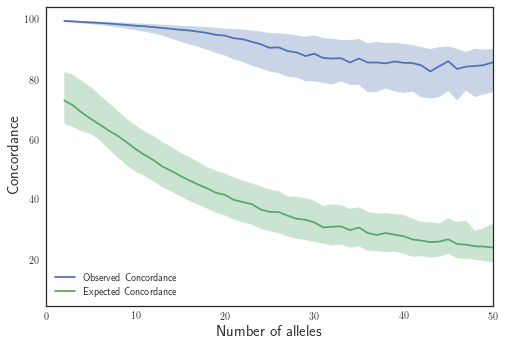

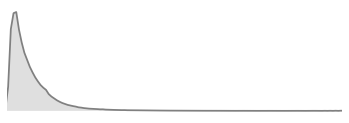

In [54]:
true_median_val = sscloo[['numAllele','loo_concordance_100']].groupby('numAllele').median().values
true_max_val = sscloo[['numAllele','loo_concordance_100']].groupby('numAllele').quantile(0.75).values
true_min_val = sscloo[['numAllele','loo_concordance_100']].groupby('numAllele').quantile(0.25).values
true_x_val = sscloo[['numAllele','loo_concordance_100']].groupby('numAllele').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

exp_median_val = sscloo[['numAllele','exp_concord_100']].groupby('numAllele').median().values
exp_max_val = sscloo[['numAllele','exp_concord_100']].groupby('numAllele').quantile(0.75).values
exp_min_val = sscloo[['numAllele','exp_concord_100']].groupby('numAllele').quantile(0.25).values
exp_x_val = sscloo[['numAllele','exp_concord_100']].groupby('numAllele').median().index.tolist()
exp_x_val = [float("%.1f"%x) for x in exp_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed Concordance")
errorfill(exp_x_val, exp_median_val, yerr=[exp_min_val[:,0], exp_max_val[:,0]], color=exp_color, label="Expected Concordance")
plt.xlim(left=0, right=50)
plt.xlabel("Number of alleles", size=15)
plt.ylabel("Concordance", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPATH, "%s_LOO_ConcordanceVsNumAlleles.pdf"%PREFIX));

# Histogram of allele num for the top
fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
kde(sscloo["numAllele"], (min(true_x_val), max(true_x_val)), color=hist_color, ax=ax, bw=0.5)
fig.savefig(os.path.join(OUTPATH, "%s_LOO_ConcordanceVsNumAlleles_DIST.pdf"%PREFIX));

# R2 vs. heterozygosity

In [55]:
exp_r2 = pd.read_csv("/storage/mgymrek/ssc-imputation/loo/tmp/10.random.locus.tab", sep="\t") # TODO get all chroms
exp_r2["pos_x"] = exp_r2.apply(lambda x: str(int(x["chrom"]))+":"+str(int(x["pos"])), 1)
sscloo_expr2 = pd.merge(sscloo, exp_r2[["pos_x","length_r2","conc"]], on=["pos_x"])
sscloo_expr2 = sscloo_expr2[sscloo_expr2["het"]<=0.8]

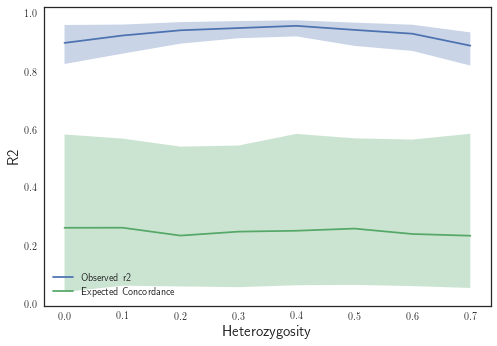

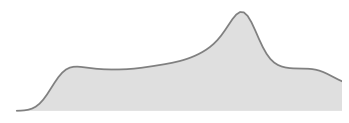

In [56]:
HETBIN=0.1
sscloo_expr2["hetbin"] = sscloo_expr2["het"].apply(lambda x: int(x/HETBIN)*HETBIN)
hetbins = np.unique(sscloo_expr2['hetbin'].values)

true_median_val = sscloo_expr2[['hetbin','loo_r2']].groupby('hetbin').median().values
true_max_val = sscloo_expr2[['hetbin','loo_r2']].groupby('hetbin').quantile(0.75).values
true_min_val = sscloo_expr2[['hetbin','loo_r2']].groupby('hetbin').quantile(0.25).values
true_x_val = sscloo_expr2[['hetbin','loo_r2']].groupby('hetbin').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

exp_median_val = sscloo_expr2[['hetbin','length_r2']].groupby('hetbin').median().values
exp_max_val = sscloo_expr2[['hetbin','length_r2']].groupby('hetbin').quantile(0.75).values
exp_min_val = sscloo_expr2[['hetbin','length_r2']].groupby('hetbin').quantile(0.25).values
exp_x_val = sscloo_expr2[['hetbin','length_r2']].groupby('hetbin').median().index.tolist()
exp_x_val = [float("%.1f"%x) for x in exp_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed r2")
errorfill(exp_x_val, exp_median_val, yerr=[exp_min_val[:,0], exp_max_val[:,0]], color=exp_color, label="Expected Concordance")
plt.xlabel("Heterozygosity", size=15)
plt.ylabel("R2", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join("%s_LOO_R2VsHet.pdf"%PREFIX));

# Histogram of hets for the top
fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
kde(sscloo["het"], (min(true_x_val), max(true_x_val)), color=hist_color, ax=ax)
fig.savefig(os.path.join(OUTPATH, "%s_LOO_ConcordanceVsHet_DIST.pdf"%PREFIX));

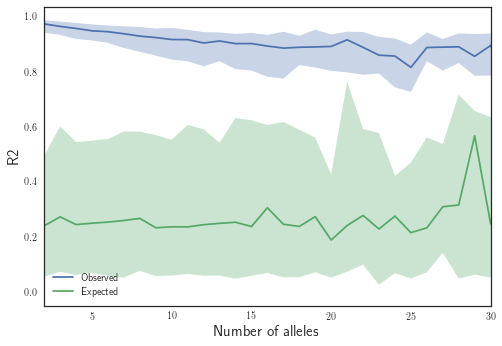

In [134]:
true_median_val = sscloo_expr2[['numAllele','loo_r2']].groupby('numAllele').median().values
true_max_val = sscloo_expr2[['numAllele','loo_r2']].groupby('numAllele').quantile(0.75).values
true_min_val = sscloo_expr2[['numAllele','loo_r2']].groupby('numAllele').quantile(0.25).values
true_x_val = sscloo_expr2[['numAllele','loo_r2']].groupby('numAllele').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

exp_median_val = sscloo_expr2[['numAllele','length_r2']].groupby('numAllele').median().values
exp_max_val = sscloo_expr2[['numAllele','length_r2']].groupby('numAllele').quantile(0.75).values
exp_min_val = sscloo_expr2[['numAllele','length_r2']].groupby('numAllele').quantile(0.25).values
exp_x_val = sscloo_expr2[['numAllele','length_r2']].groupby('numAllele').median().index.tolist()
exp_x_val = [float("%.1f"%x) for x in exp_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed")
errorfill(exp_x_val, exp_median_val, yerr=[exp_min_val[:,0], exp_max_val[:,0]], color=exp_color, label="Expected")
plt.xlim(left=2, right=30)
plt.xlabel("Number of alleles", size=15)
plt.ylabel("R2", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join("%s_LOO_R2VsNumAlleles.pdf"%PREFIX));

# Figure 2C Allele-r2 vs. frequency

In [76]:
exp_ar2 = pd.read_csv("/storage/mgymrek/ssc-imputation/loo/tmp/10.random.allele.tab", sep="\t")
exp_ar2["locus1"] = exp_ar2.apply(lambda x: str(int(x["chrom"]))+":"+str(int(x["pos"])), 1)
exp_ar2["exp_allele_r2"] = exp_ar2["allele_r2"]

ar2 = pd.read_csv(os.path.join(DATADIR, "loo","l1o.allelic.v3.tab"), delim_whitespace=True)
ar2 = pd.merge(exp_ar2[["locus1","exp_allele_r2","allele"]], ar2, on=["locus1", "allele"])

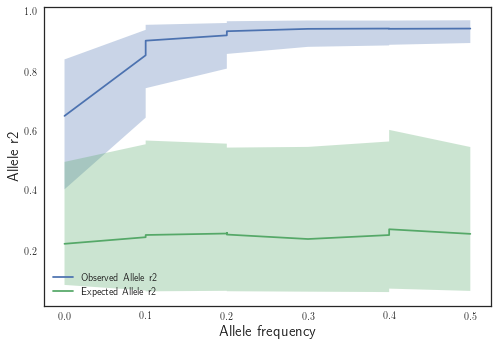

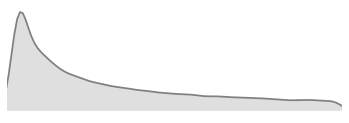

In [77]:
FREQBIN=0.05 
ar2["freqbin"] = ar2["freq_het"].apply(lambda x: int(min([x,1-x])/FREQBIN)*FREQBIN)
ar2 = ar2[(ar2["freq_het"]>=0.01) & (ar2["freq_het"]<0.5)]
fbins = np.unique(ar2['freqbin'].values)
true_median_val = ar2[['freqbin','r2']].groupby('freqbin').median().values
true_max_val = ar2[['freqbin','r2']].groupby('freqbin').quantile(0.75).values
true_min_val = ar2[['freqbin','r2']].groupby('freqbin').quantile(0.25).values
true_x_val = ar2[['freqbin','r2']].groupby('freqbin').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

exp_median_val = ar2[['freqbin','exp_allele_r2']].groupby('freqbin').median().values
exp_max_val = ar2[['freqbin','exp_allele_r2']].groupby('freqbin').quantile(0.75).values
exp_min_val = ar2[['freqbin','exp_allele_r2']].groupby('freqbin').quantile(0.25).values
exp_x_val = ar2[['freqbin','exp_allele_r2']].groupby('freqbin').median().index.tolist()
exp_x_val = [float("%.1f"%x) for x in exp_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed Allele r2")
errorfill(exp_x_val, exp_median_val, yerr=[exp_min_val[:,0], exp_max_val[:,0]], color=exp_color, label="Expected Allele r2")
plt.xlabel("Allele frequency", size=15)
plt.ylabel("Allele r2", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPATH, "%s_LOO_AlleleR2VsFreq.pdf"%PREFIX));


# Histogram of allele num for the top
fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
kde(ar2["freq_het"], (min(true_x_val), max(true_x_val)), color=hist_color, ax=ax, bw=0.01)
fig.savefig(os.path.join(OUTPATH, "%s_LOO_AlleleR2VsFreq_DIST.pdf"%PREFIX));

# Compare LOO vs. 1000G

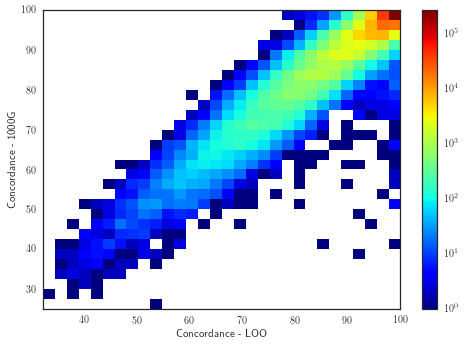

In [117]:
x = sscloo[~np.isnan(sscloo["wgs_eur_concordance_100"]) & ~np.isnan(sscloo["loo_concordance_100"])]["loo_concordance_100"]
y = sscloo[~np.isnan(sscloo["wgs_eur_concordance_100"]) & ~np.isnan(sscloo["loo_concordance_100"])]["wgs_eur_concordance_100"] 
plt.hist2d(x, y, bins=30, norm=LogNorm(), cmap=mycmap)
plt.colorbar()
plt.xlabel("Concordance - LOO")
plt.ylabel("Concordance - 1000G")
plt.savefig(os.path.join(OUTPATH, "%s_SSCvs1KGConc_v2.pdf"%PREFIX));

In [52]:
onekg_r2 = pd.read_csv(os.path.join(DATADIR, "onekg", "ALL.eur.allelic.v3.tab"), delim_whitespace=True)
onekg_r2["kgr2"] = onekg_r2["r2"]
onekg_r2 = onekg_r2[onekg_r2["freq_het"]>=MINFREQ]
onekg_r2 = pd.merge(onekg_r2[["locus1","allele","kgr2"]], ar2[["locus1","allele","r2","freq_het"]], on=["locus1","allele"])
onekg_r2 = onekg_r2[~np.isnan(onekg_r2.kgr2) & ~np.isnan(onekg_r2.r2) & (onekg_r2["freq_het"]>=MINFREQ)]

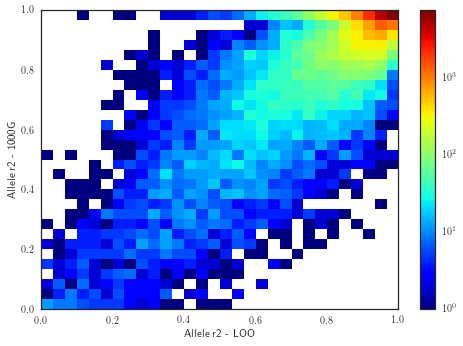

In [135]:
x = onekg_r2["r2"]
y = onekg_r2["kgr2"]
plt.hist2d(x, y, bins=30, norm=LogNorm(), cmap=mycmap)
plt.colorbar()
plt.xlabel("Allele r2 - LOO")
plt.ylabel("Allele r2 - 1000G")
plt.savefig(os.path.join(OUTPATH, "%s_SSCvs1KGAlleleR2_v2.pdf"%PREFIX));

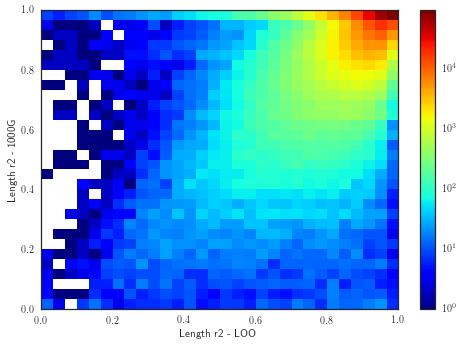

In [115]:
x = sscloo[~np.isnan(sscloo["loo_r2"]) & ~np.isnan(sscloo["wgs_eur_r2"])]["loo_r2"]
y = sscloo[~np.isnan(sscloo["loo_r2"]) & ~np.isnan(sscloo["wgs_eur_r2"])]["wgs_eur_r2"] 
plt.hist2d(x, y, bins=30, norm=LogNorm(), cmap=mycmap)
plt.colorbar()
plt.xlabel("Length r2 - LOO")
plt.ylabel("Length r2 - 1000G")
plt.savefig(os.path.join(OUTPATH, "%s_SSCvs1KGR2.pdf"%PREFIX));

# Supplementary: concordance vs. mutation rate

In [14]:
mutrate = pd.read_csv("/storage/mgymrek/ssc-denovos/mutea-results/ssc_mutea_auto_scaled.bed.gz", sep="\t",
                     names=["chrom","start","log10mu"], usecols=[0,1,3])
mutrate = pd.merge(mutrate, sscloo, on=["chrom","start"])
mutrate = mutrate[(mutrate["log10mu"]>=-6) & (mutrate["log10mu"]<=-2)]

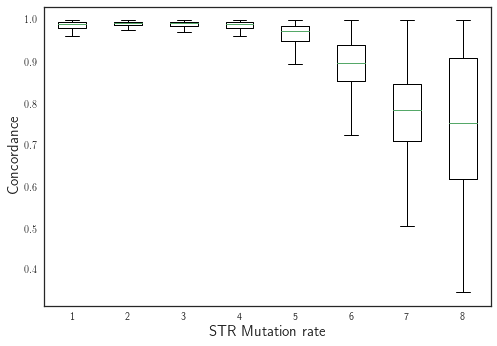

In [17]:
MUTBIN=0.5
mutrate["mutbin"] = mutrate["log10mu"].apply(lambda x: int(x/MUTBIN)*MUTBIN)
mbins = np.unique(mutrate['mutbin'].values)
fullList = list()
for i in mbins:
    fullList.append((mutrate[(mutrate.mutbin==i)]['loo_concordance']))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(fullList);
ax.set_xlabel("STR Mutation rate", size=15)
ax.set_ylabel("Concordance", size=15)
#ax.set_xticklabels(labels, size=12)
#ax.set_yticklabels(["%.2f"%(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "%s_LOO_ConcVsMutrate.pdf"%PREFIX));

# Table 1

In [74]:
# Get r2, concordance for all categories

# Get separately for things with >=3 alleles
ssc_mult = sscloo[sscloo["numAllele"]>=3]

ssc = ["SSC - LOO", sscloo.shape[0], np.mean(sscloo["loo_concordance"]), np.mean(sscloo["exp_concordance"]), np.mean(sscloo["loo_r"].apply(lambda x: x**2)),
       np.mean(ar2[ar2["freq_het"]>=MINFREQ]["r2"])]
ssc_m = ["SSC - LOO (multi)", ssc_mult.shape[0], np.mean(ssc_mult["loo_concordance"]), np.mean(ssc_mult["exp_concordance"]), np.mean(ssc_mult["loo_r"].apply(lambda x: x**2))]

kg_eur = ["1000G-EUR", sscloo.shape[0], np.mean(sscloo["wgs_eur_concordance"]), np.mean(sscloo["wgs_eur_r"].apply(lambda x: x**2)),
         np.mean(onekg_r2[onekg_r2["freq_het"]>=MINFREQ]["r2"])]
kg_eur_m = ["1000G-EUR (multi)", ssc_mult.shape[0], np.mean(ssc_mult["wgs_eur_concordance"]), np.mean(ssc_mult["wgs_eur_r"].apply(lambda x: x**2))]
    
onekg_r2_afr = pd.read_csv(os.path.join(DATADIR, "onekg", "ALL.afr.allelic.v3.tab"), sep="\t")
kg_afr = ["1000G-AFR", sscloo.shape[0], np.mean(sscloo["wgs_afr_concordance"]), np.mean(sscloo["wgs_afr_r"].apply(lambda x: x**2)),
         np.mean(onekg_r2_afr[onekg_r2_afr["freq_het"]>=MINFREQ]["r2"])]

kg_afr_m = ["1000G-AFR (multi)", ssc_mult.shape[0], np.mean(ssc_mult["wgs_afr_concordance"]), np.mean(ssc_mult["wgs_afr_r"].apply(lambda x: x**2))]

onekg_r2_eas = pd.read_csv(os.path.join(DATADIR, "onekg", "ALL.eas.allelic.v3.tab"), sep="\t")
kg_eas = ["1000G-EAS", sscloo.shape[0], np.mean(sscloo["wgs_eas_concordance"]), np.mean(sscloo["wgs_eas_r"].apply(lambda x: x**2)),
         np.mean(onekg_r2_eas[onekg_r2_eas["freq_het"]>=MINFREQ]["r2"])]
kg_eas_m = ["1000G-EAS (multi)", ssc_mult.shape[0], np.mean(ssc_mult["wgs_eas_concordance"]), np.mean(ssc_mult["wgs_eas_r"].apply(lambda x: x**2))]

for data in [ssc, ssc_m, kg_eur, kg_eur_m, kg_afr, kg_afr_m, kg_eas, kg_eas_m]:
    print("\t".join([str(item) for item in data]))

SSC - LOO	445735	0.9672236129937938	0.9062427624677614	0.8667501346339181
SSC - LOO (multi)	427595	0.9661064270284997	0.9041139204470784
1000G-EUR	445735	0.9708627613166793	0.9210846332861465	0.8767023324988875
1000G-EUR (multi)	427595	0.969802998779962	0.9189688950147161
1000G-AFR	445735	0.9067710124129755	0.7460792198338507	0.700136346279872
1000G-AFR (multi)	427595	0.9037584639835781	0.7421835077632993
1000G-EAS	445735	0.9380028364424341	0.8234038969308328	0.7738294451520232
1000G-EAS (multi)	427595	0.9357935739657504	0.8193003353357599


# Supplemental: SNP-SNP vs. SNP-STR LD

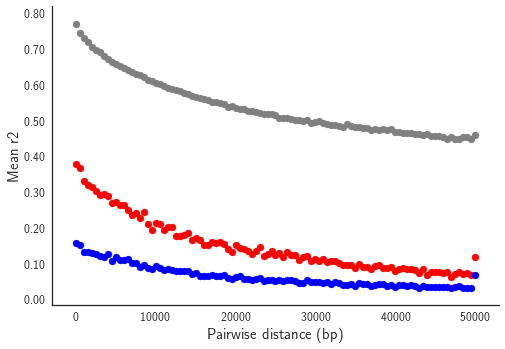

In [21]:
BINSIZE=500
# Load SNPSTR
snpsnp = pd.read_csv(os.path.join("/storage/mgymrek/ssc-imputation/", "snpstr-ld", "snp_pairwise_ld_chr21.tab"), sep="\t",
                    names=["distance","r2"])
snpstr = pd.read_csv(os.path.join("/storage/mgymrek/ssc-imputation/", "snpstr-ld", "snp_str_ld_chr21.tab"), sep="\t",
                      usecols=[0,1,3,6])
snpstr["chrom"] = snpstr["locus1"].apply(lambda x: x.split(":")[0])
snpstr["start"] = snpstr["locus1"].apply(lambda x: int(x.split(":")[1]))
snpstr["distance"] = snpstr.apply(lambda x: abs(int(x["locus1"].split(":")[1])-int(x["locus2"].split(":")[1])), 1)

# Load SNPSTR - allele
snpstr_a = pd.read_csv(os.path.join("/storage/mgymrek/ssc-imputation/", "snpstr-ld", "snp_str_ld_chr21_allele.tab"), sep="\t",
                      usecols=[0,1,2,3,6])
snpstr_a = snpstr_a[~np.isnan(snpstr_a["r2"])]
snpstr_a["chrom"] = snpstr_a["locus1"].apply(lambda x: x.split(":")[0])
snpstr_a["start"] = snpstr_a["locus1"].apply(lambda x: int(x.split(":")[1]))
snpstr_a["distance"] = snpstr_a.apply(lambda x: abs(int(x["locus1"].split(":")[1])-int(x["locus2"].split(":")[1])), 1)

snpstr_best = snpstr.groupby("start", as_index=False).agg({"r2": max, "freq_het": np.mean})
snpstr_best_a = snpstr_a.groupby("start", as_index=False).agg({"r2": max,"freq_het": np.mean})

snpsnp["distbin"] = (snpsnp["distance"]/BINSIZE).apply(int)
snpsnp_bins = snpsnp.groupby("distbin", as_index=False).agg({"r2": np.mean})

snpstr["distbin"] = (snpstr["distance"].apply(abs)/BINSIZE).apply(int)
snpstr_bins = snpstr.groupby("distbin", as_index=False).agg({"r2": np.mean})

snpstr_a["distbin"] = (snpstr_a["distance"].apply(abs)/BINSIZE).apply(int)
snpstr_a_bins = snpstr_a.groupby("distbin", as_index=False).agg({"r2": np.mean})


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(snpsnp_bins["distbin"]*BINSIZE, snpsnp_bins["r2"], color="gray");
ax.scatter(snpstr_bins["distbin"]*BINSIZE, snpstr_bins["r2"], color="red");
ax.scatter(snpstr_a_bins["distbin"]*BINSIZE, snpstr_a_bins["r2"], color="blue");

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Pairwise distance (bp)", size=15)
ax.set_ylabel("Mean r2", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.2f"%(x) for x in ax.get_yticks()], size=12);

fig.savefig(os.path.join(OUTPATH, "SuppFig_SnpStrLD.pdf"))

In [63]:
best_snp = pd.read_csv("/storage/s1saini/manuscript_strsnp/fig3/snp_str_ld/chr20_snp_str_ld_50k.txt", sep="\t")
best_snp["str"] = best_snp["locus1"]
best_snp["snp_difference"] = best_snp.apply(lambda x: abs(int(x["locus2"].split(":")[1]) - int(x["locus1"].split(":")[1])), 1)
best_snp = best_snp.iloc[best_snp.groupby('locus1').agg({'r2':'idxmax'}).r2][['str','snp_difference']]
best_snp["pos_x"] = best_snp["str"]
best_snp = pd.merge(sscloo, best_snp, on=["pos_x"])

In [64]:
ar2 = pd.read_csv(os.path.join(DATADIR, "loo","l1o.allelic.v3.tab"), delim_whitespace=True)
best_snp["locus1"] = best_snp.apply(lambda x: str(x["chrom"])+":"+str(x["start"]), 1)
ar2_best = pd.merge(best_snp[["locus1","snp_difference"]], ar2, on=["locus1"])
ar2_best = ar2_best[~np.isnan(ar2_best["r2"])]

2303.5
5746.457974137931


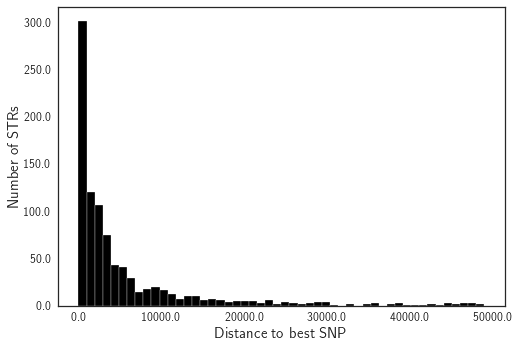

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(best_snp["snp_difference"], color="black", edgecolor="white", bins=50);
ax.set_xlabel("Distance to best SNP", size=15)
ax.set_ylabel("Number of STRs", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_BestSNP.pdf"))
print(np.median(best_snp["snp_difference"]))
print(np.mean(best_snp["snp_difference"]))

(-0.06135805525294617, 0.06170669093314123)
(-0.036368635839108064, 0.2683916450968713)
(-0.06403266400903139, 7.515589195222459e-05)


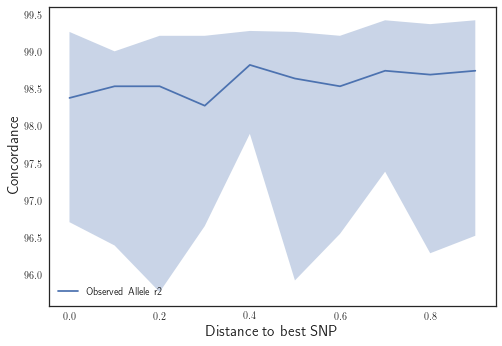

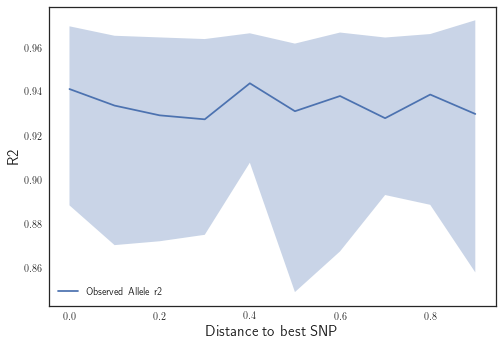

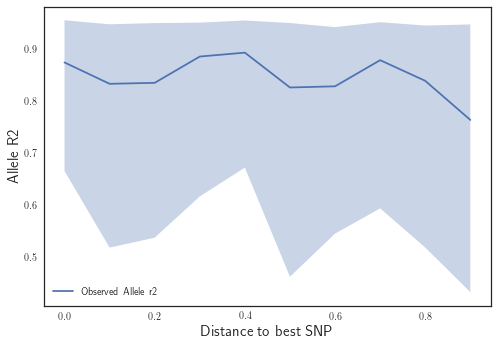

In [82]:
#SNPBIN = 5000 # TODO bin by deciles?
best_snp = best_snp.sort_values("snp_difference")
ar2_best = ar2_best.sort_values("snp_difference")

#best_snp["snpbin"] = best_snp["snp_difference"].apply(lambda x: int(x/SNPBIN)*SNPBIN)
SNPBIN = 0.10
best_snp["snpbin"] = [int(item*1.0/best_snp.shape[0]/SNPBIN)*SNPBIN for item in range(best_snp.shape[0])]
ar2_best["snpbin"] = [int(item*1.0/ar2_best.shape[0]/SNPBIN)*SNPBIN for item in range(ar2_best.shape[0])]

snpbins = np.unique(best_snp['snpbin'].values)

# Concordance vs. best SNP
true_median_val = best_snp[['snpbin','loo_concordance_100']].groupby('snpbin').median().values
true_max_val = best_snp[['snpbin','loo_concordance_100']].groupby('snpbin').quantile(0.75).values
true_min_val = best_snp[['snpbin','loo_concordance_100']].groupby('snpbin').quantile(0.25).values
true_x_val = best_snp[['snpbin','loo_concordance_100']].groupby('snpbin').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed Allele r2")
plt.xlabel("Distance to best SNP", size=15)
plt.ylabel("Concordance", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPATH, "BESTSNP_conc.pdf"))
print(scipy.stats.pearsonr(best_snp["snp_difference"], best_snp["loo_concordance"]))

# R2 vs. best SNP
true_median_val = best_snp[['snpbin','loo_r2']].groupby('snpbin').median().values
true_max_val = best_snp[['snpbin','loo_r2']].groupby('snpbin').quantile(0.75).values
true_min_val = best_snp[['snpbin','loo_r2']].groupby('snpbin').quantile(0.25).values
true_x_val = best_snp[['snpbin','loo_r2']].groupby('snpbin').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed Allele r2")
plt.xlabel("Distance to best SNP", size=15)
plt.ylabel("R2", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPATH, "BESTSNP_R2.pdf"))
print(scipy.stats.pearsonr(best_snp["snp_difference"], best_snp["loo_r2"]))


# Allele R2 vs. best SNP
true_median_val = ar2_best[['snpbin','r2']].groupby('snpbin').median().values
true_max_val = ar2_best[['snpbin','r2']].groupby('snpbin').quantile(0.75).values
true_min_val = ar2_best[['snpbin','r2']].groupby('snpbin').quantile(0.25).values
true_x_val = ar2_best[['snpbin','r2']].groupby('snpbin').median().index.tolist()
true_x_val = [float("%.1f"%x) for x in true_x_val]

plt.figure()
errorfill(true_x_val, true_median_val, yerr=[true_min_val[:,0], true_max_val[:,0]], color=true_color, label="Observed Allele r2")
plt.xlabel("Distance to best SNP", size=15)
plt.ylabel("Allele R2", size=15)
plt.legend(loc="lower left")
plt.savefig(os.path.join(OUTPATH, "BESTSNP_AlleleR2.pdf"))
print(scipy.stats.pearsonr(ar2_best["snp_difference"], ar2_best["r2"]))

# Scratch

In [22]:
ssc_vs_onekg = sscloo[['loo_concordance', 'wgs_eur_concordance']].dropna()
print("Concordance ", scipy.stats.pearsonr(ssc_vs_onekg.iloc[:,0], ssc_vs_onekg.iloc[:,1]))
ssc_vs_onekg = sscloo[['loo_r', 'wgs_eur_r']].dropna()
print("r ", scipy.stats.pearsonr(ssc_vs_onekg.iloc[:,0]**2, ssc_vs_onekg.iloc[:,1]**2))


Concordance  (0.9406240172244376, 0.0)
r  (0.6371847136066084, 0.0)
